### Motor Vehicle Collisions in NYC, classified using Random Forest
### Authors: Jack Robbins & Daniyal Khan

**Dataset Used**: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [64]:
# Important imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
from matplotlib.gridspec import GridSpec

In [65]:
# Read in our dataframe
collisions = pd.read_csv("data/Motor_Vehicle_Collisions_-_Crashes_20241116.csv", low_memory=False)

In [66]:
# Let's get an idea of our data
collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [67]:
# We can see that we have quit a few rows
collisions.shape

(2134659, 29)

## Data Preprocessing 

In [68]:
null_values=collisions.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           663229
ZIP CODE                          663491
LATITUDE                          239393
LONGITUDE                         239393
LOCATION                          239393
ON STREET NAME                    457554
CROSS STREET NAME                 813846
OFF STREET NAME                  1769478
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       7203
CONTRIBUTING FACTOR VEHICLE 2     335261
CONTRIBUTING FACTOR VEHICLE 3    1981119
CONTRIBUTING FACTOR VEHICLE 4    2099762
CONTRIBUTING FACTOR VEHICLE 5    2125151
COLLISION_ID                  

## Let's analyze these findings...
So we can see that there are a lot of missing values specifically for vehicles above code type 2. This is probably because there aren't that many 3, 4 or 5 car collisions in NYC. So instead of dropping rows where these are null, we may as well simply drop these columns. This also applies to the "CONTRIBUTING FACTOR VEHICLE.." columns for 3, 4 and 5. In fact, I am going to drop the rows where these aren't null, because I only care about one/two car collisions.

In [69]:
collisions.drop(['VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', \
                 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', \
                 'CONTRIBUTING FACTOR VEHICLE 5'], axis=1, inplace=True)

In [70]:
collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,4455765,Sedan,Sedan
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,0,0,0,1,0,Pavement Slippery,NaN,4513547,Sedan,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,0,0,0,0,0,Following Too Closely,Unspecified,4541903,Sedan,Pick-up Truck
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,0,0,0,0,0,Unspecified,NaN,4456314,Sedan,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,0,0,0,0,0,NaN,NaN,4486609,NaN,NaN


### Dropping NA's
Let's remove anything where the position or location of the crash was improperly recorded.

In [71]:
collisions.dropna(subset=['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION'], how='any', inplace=True)

As we can see now, we should have borough and position data for every single crash

In [72]:
collisions

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,0,0,0,0,0,Unspecified,NaN,4456314,Sedan,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,0,0,0,0,0,NaN,NaN,4486609,NaN,NaN
7,12/14/2021,8:17,BRONX,10475,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,0,0,0,2,0,Unspecified,Unspecified,4486660,Sedan,Sedan
8,12/14/2021,21:10,BROOKLYN,11207,40.671720,-73.897100,"(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,0,0,0,0,0,Driver Inexperience,Unspecified,4487074,Sedan,NaN
9,12/14/2021,14:58,MANHATTAN,10017,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,NaN,...,0,0,0,0,0,Passing Too Closely,Unspecified,4486519,Sedan,Station Wagon/Sport Utility Vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134607,07/10/2024,18:34,BRONX,10454,40.812263,-73.920590,"(40.812263, -73.92059)",WILLIS AVENUE,EAST 143 STREET,NaN,...,0,0,0,0,0,Unspecified,NaN,4746499,Taxi,NaN
2134616,07/19/2024,18:00,BROOKLYN,11207,40.675735,-73.896860,"(40.675735, -73.89686)",ATLANTIC AVENUE,PENNSYLVANIA AVENUE,NaN,...,0,0,0,0,0,Turning Improperly,Unspecified,4746359,Sedan,Sedan
2134633,07/07/2024,14:12,BRONX,10468,40.861084,-73.911490,"(40.861084, -73.91149)",NaN,NaN,2258 HAMPDEN PLACE,...,0,0,0,0,0,Unspecified,NaN,4746320,Sedan,NaN
2134643,07/21/2024,18:05,BROOKLYN,11224,40.572968,-74.000595,"(40.572968, -74.000595)",NaN,NaN,3514 SURF AVENUE,...,0,0,0,0,0,Backing Unsafely,Unspecified,4746425,Station Wagon/Sport Utility Vehicle,Pick-up Truck


In [73]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                             0
CRASH TIME                             0
BOROUGH                                0
ZIP CODE                               0
LATITUDE                               0
LONGITUDE                              0
LOCATION                               0
ON STREET NAME                    323162
CROSS STREET NAME                 323702
OFF STREET NAME                  1111148
NUMBER OF PERSONS INJURED             11
NUMBER OF PERSONS KILLED              23
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       5416
CONTRIBUTING FACTOR VEHICLE 2     238065
COLLISION_ID                           0
VEHICLE TYPE CODE 1                10507
VEHICLE TYPE CODE 2               292029
dtype: int64


## Removing unneeded columns
So we're definitely in a better spot now, but there is still much more that we can do. Firstly, we can see those "STREET NAME" columns have a lot of null values in them. Since the name of the street is too atomic to be useful for our regression equation, we can just get rid of those columns entirely. We can also see that every crash has a unique crash ID given to it by the NYPD. Again, this won't help us all with regression, so we'll scrap it as well. Finally, the contributing factor column is not a standardized categorical column. The data in there are manually entered strings that would also not be of much use to us. Additionally, the crash date itself may be a pain to work with, and I don't foresee it coming up much for us. Location and zip code are other strange columns, as they are just proxies for latitude and longitude.

In [74]:
# Drop all of these columns in here
collisions.drop(['LOCATION','CROSS STREET NAME', 'OFF STREET NAME', 'COLLISION_ID', \
                 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'ZIP CODE'], axis=1, inplace=True)

In [75]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                            0
CRASH TIME                            0
BOROUGH                               0
LATITUDE                              0
LONGITUDE                             0
ON STREET NAME                   323162
NUMBER OF PERSONS INJURED            11
NUMBER OF PERSONS KILLED             23
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
VEHICLE TYPE CODE 1               10507
VEHICLE TYPE CODE 2              292029
dtype: int64


## Dropping NA's in the remaining rows/columns
We're doing much better now. We still have around 250,000 columns with at least one NA. For our purposes here, since we have around 2 million rows, we can acceptably lose that data, so we'll now drop any rows with an NA

In [76]:
collisions.dropna(how='any', axis=0, inplace=True)

In [77]:
# Let's see how we're doing now...
null_values=collisions.isnull().sum()
print("Our null values now:\n", null_values)

Our null values now:
 CRASH DATE                       0
CRASH TIME                       0
BOROUGH                          0
LATITUDE                         0
LONGITUDE                        0
ON STREET NAME                   0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
dtype: int64


In [78]:
# Let's see what how much we still have left over
collisions.shape

(927203, 16)

### Dealing with time and type mismatches

Even though the data is cleaned from NA's, we still can't use it. Our dataset is still filled with categorical data that we'll need to encode numerically if we want to do any correlation analysis or regression on it.

In [79]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927203 entries, 9 to 2134616
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     927203 non-null  object 
 1   CRASH TIME                     927203 non-null  object 
 2   BOROUGH                        927203 non-null  object 
 3   LATITUDE                       927203 non-null  float64
 4   LONGITUDE                      927203 non-null  float64
 5   ON STREET NAME                 927203 non-null  object 
 6   NUMBER OF PERSONS INJURED      927203 non-null  float64
 7   NUMBER OF PERSONS KILLED       927203 non-null  float64
 8   NUMBER OF PEDESTRIANS INJURED  927203 non-null  int64  
 9   NUMBER OF PEDESTRIANS KILLED   927203 non-null  int64  
 10  NUMBER OF CYCLIST INJURED      927203 non-null  int64  
 11  NUMBER OF CYCLIST KILLED       927203 non-null  int64  
 12  NUMBER OF MOTORIST INJURED   

As we can see, there are several columns that are Objects(really strings) that we'll need to encode. A special case though is the crash date and crash time. We can convert crash time specifically into an integer representing the number of minutes since midnight by doing hours*60 + minutes. We'll use the help of a custom function for this.

In [80]:
def clock_time_to_minutes(clock_time):
    #Split the clock time along the colon
    split = clock_time.split(":")
    return int(split[1])*60 + int(split[0])

#Apply this to the CRASH TIME
collisions['CRASH TIME'] = collisions['CRASH TIME'].apply(clock_time_to_minutes)
    
def date_to_months(date):
    #Grab the month
    split = date.split("/")
    return int(split[0])

#Apply this to a DATE
collisions['CRASH MONTH'] = collisions['CRASH DATE'].apply(date_to_months)
collisions.drop(['CRASH DATE'], axis = 1,  inplace=True)

In [81]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927203 entries, 9 to 2134616
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH TIME                     927203 non-null  int64  
 1   BOROUGH                        927203 non-null  object 
 2   LATITUDE                       927203 non-null  float64
 3   LONGITUDE                      927203 non-null  float64
 4   ON STREET NAME                 927203 non-null  object 
 5   NUMBER OF PERSONS INJURED      927203 non-null  float64
 6   NUMBER OF PERSONS KILLED       927203 non-null  float64
 7   NUMBER OF PEDESTRIANS INJURED  927203 non-null  int64  
 8   NUMBER OF PEDESTRIANS KILLED   927203 non-null  int64  
 9   NUMBER OF CYCLIST INJURED      927203 non-null  int64  
 10  NUMBER OF CYCLIST KILLED       927203 non-null  int64  
 11  NUMBER OF MOTORIST INJURED     927203 non-null  int64  
 12  NUMBER OF MOTORIST KILLED    

We can also see that Number of persons injured/killed is a float. Since we can't have fractional parts of people, we'll convert these into ints.

In [82]:
collisions['NUMBER OF PERSONS INJURED'] = collisions['NUMBER OF PERSONS INJURED'].apply(lambda x: int(x))
collisions['NUMBER OF PERSONS KILLED'] = collisions['NUMBER OF PERSONS KILLED'].apply(lambda x: int(x))
collisions = collisions[collisions['NUMBER OF PERSONS INJURED'] <= 10]

In [83]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927106 entries, 9 to 2134616
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH TIME                     927106 non-null  int64  
 1   BOROUGH                        927106 non-null  object 
 2   LATITUDE                       927106 non-null  float64
 3   LONGITUDE                      927106 non-null  float64
 4   ON STREET NAME                 927106 non-null  object 
 5   NUMBER OF PERSONS INJURED      927106 non-null  int64  
 6   NUMBER OF PERSONS KILLED       927106 non-null  int64  
 7   NUMBER OF PEDESTRIANS INJURED  927106 non-null  int64  
 8   NUMBER OF PEDESTRIANS KILLED   927106 non-null  int64  
 9   NUMBER OF CYCLIST INJURED      927106 non-null  int64  
 10  NUMBER OF CYCLIST KILLED       927106 non-null  int64  
 11  NUMBER OF MOTORIST INJURED     927106 non-null  int64  
 12  NUMBER OF MOTORIST KILLED    

### Encoding Categorical Data
We're almost there, but we still have 3 categorical data columns in the VEHICLE TYPE CODE columns and BOROUGH columns. We will use label encoding to assign these all corresponding numerical values.

In [84]:
borough_le = preprocessing.LabelEncoder()
# Note that we want to use the same label encoder for both type code sets
typecode_le = preprocessing.LabelEncoder()
# Use a label encoder for ON STREET NAME
street_name_le = preprocessing.LabelEncoder()

collisions['BOROUGH'] = borough_le.fit_transform(collisions['BOROUGH'])
typecode_le.fit(collisions['VEHICLE TYPE CODE 1'].values.tolist() + collisions['VEHICLE TYPE CODE 2'].values.tolist())
collisions['VEHICLE TYPE CODE 1'] = typecode_le.transform(collisions['VEHICLE TYPE CODE 1'])
collisions['VEHICLE TYPE CODE 2'] = typecode_le.transform(collisions['VEHICLE TYPE CODE 2'])
collisions['ON STREET NAME'] = street_name_le.fit_transform(collisions['ON STREET NAME'])

/tmp/ipykernel_15101/3841278056.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collisions['BOROUGH'] = borough_le.fit_transform(collisions['BOROUGH'])
/tmp/ipykernel_15101/3841278056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collisions['VEHICLE TYPE CODE 1'] = typecode_le.transform(collisions['VEHICLE TYPE CODE 1'])
/tmp/ipykernel_15101/3841278056.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [85]:
collisions

,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,CRASH MONTH
9,3494,2,40.751440,-73.973970,929,0,0,0,0,0,0,0,0,899,922,12
11,3016,3,40.675884,-73.755770,9591,0,0,0,0,0,0,0,0,899,922,12
14,623,3,40.666840,-73.789410,7943,2,0,0,0,0,0,2,0,899,899,12
18,2599,0,40.872620,-73.904686,11183,1,0,0,0,0,0,1,0,922,899,12
24,2417,4,40.631650,-74.087620,10364,1,0,0,0,0,0,1,0,899,899,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134570,1816,2,40.760790,-73.984520,11033,0,0,0,0,0,0,0,0,73,922,7
2134578,12,1,40.685658,-73.985695,3943,1,0,0,0,1,0,0,0,922,115,8
2134581,323,2,40.749130,-73.988240,10999,1,0,0,0,1,0,0,0,115,922,8
2134585,2709,3,40.684383,-73.790180,442,4,0,0,0,0,0,4,0,899,922,7


Great, we've still got about 1.1 million rows of clean, null-free data remaining for us to play around with. We can now move on to searching for correlations in the dataset.

## Data Visualization - Hunting for correlations & patterns

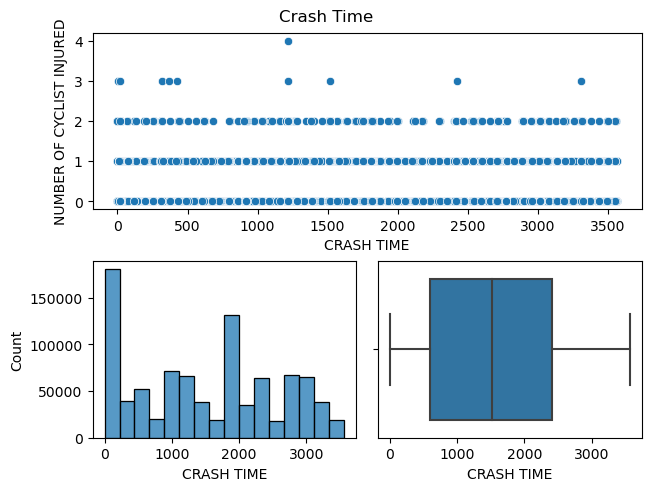

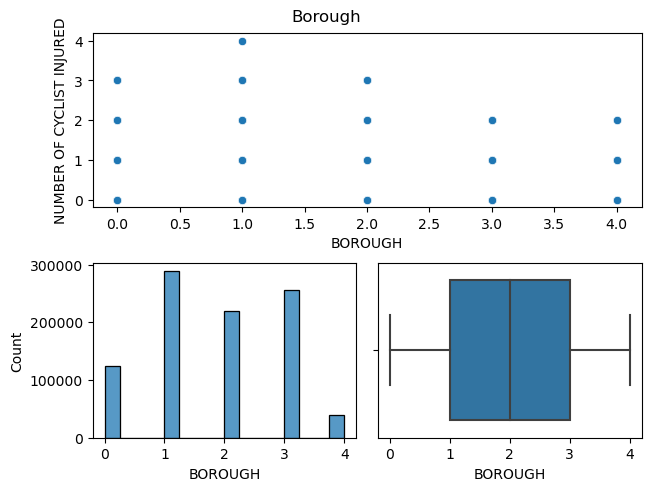

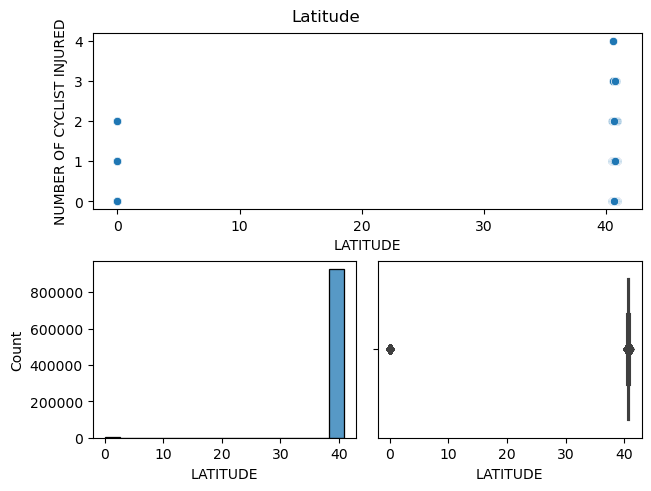

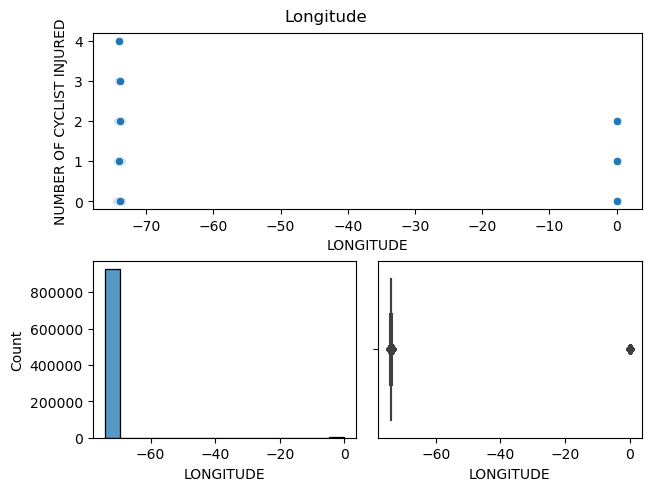

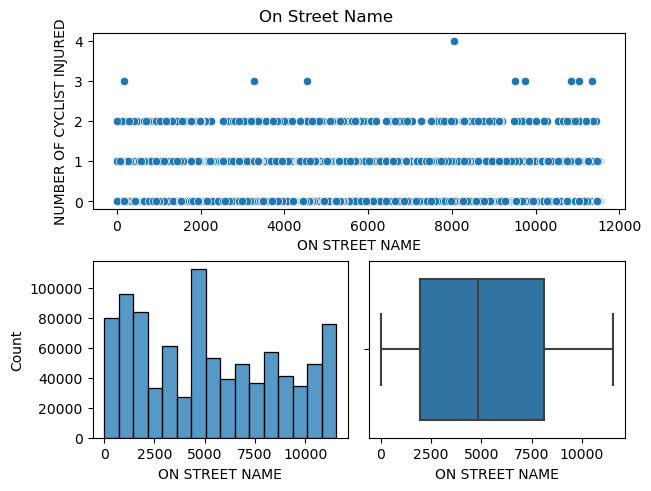

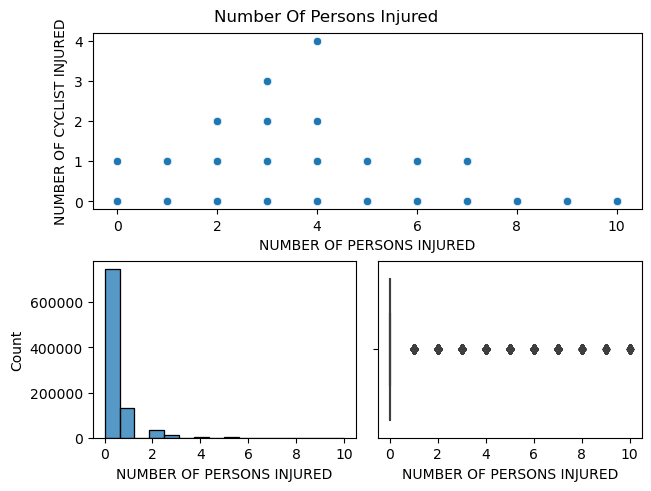

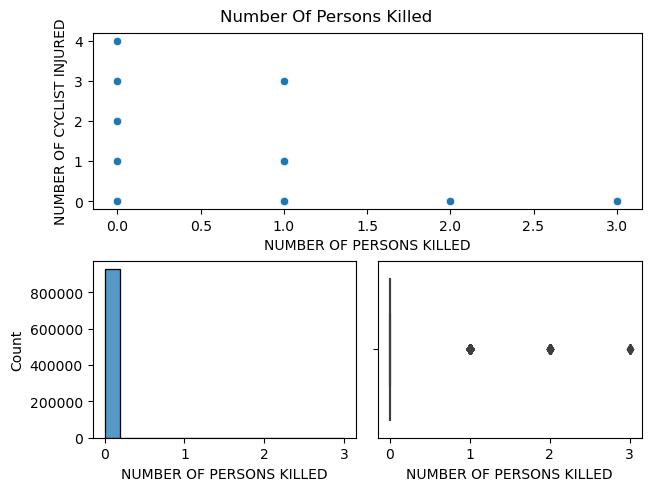

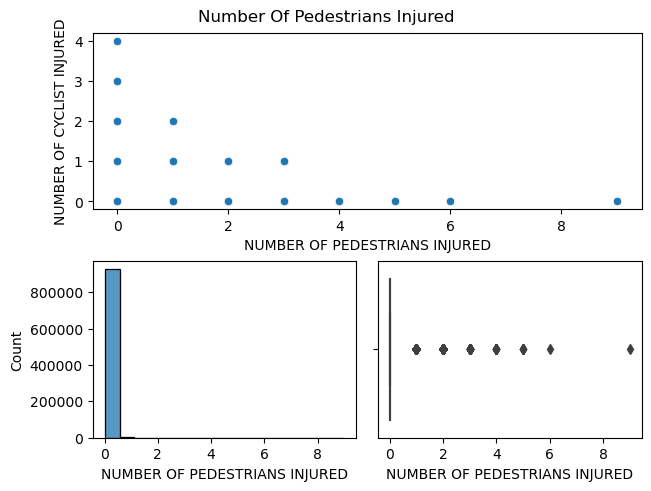

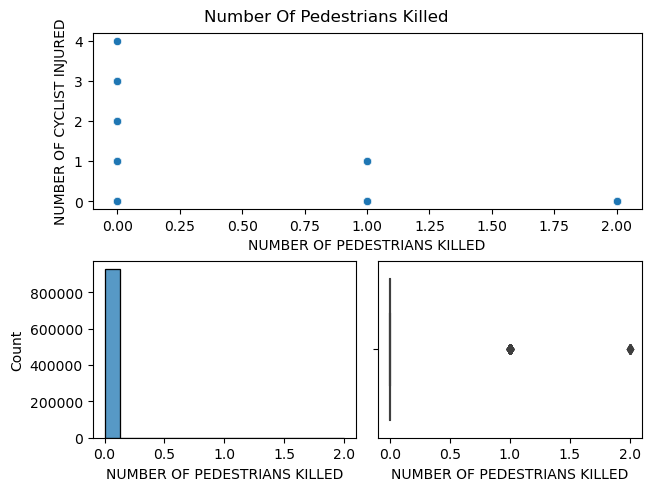

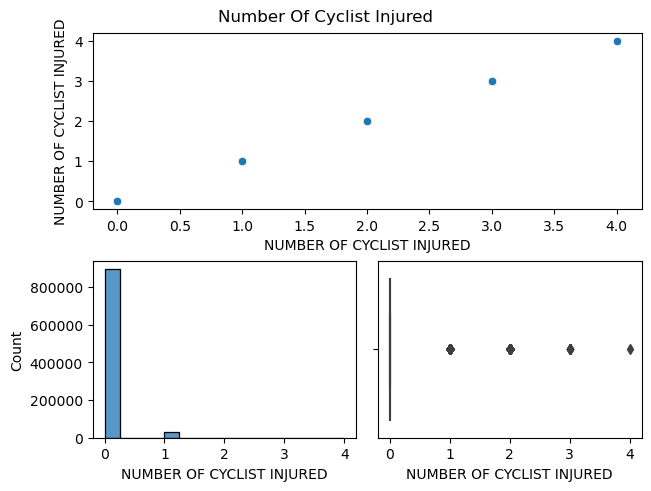

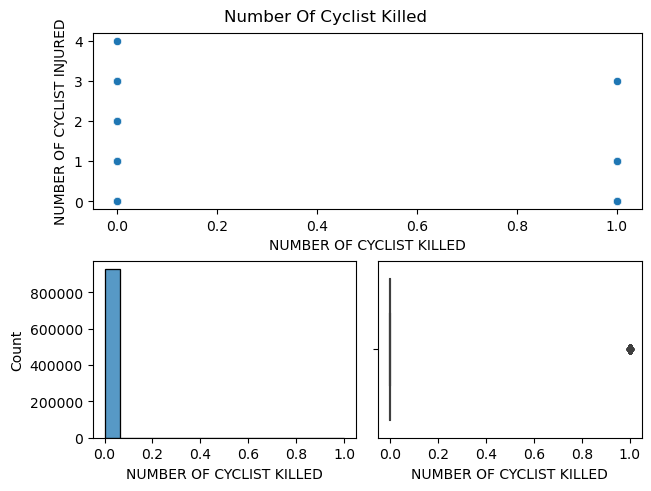

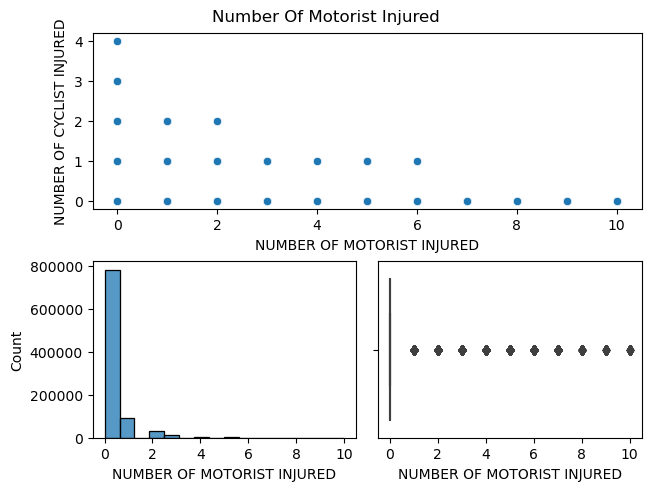

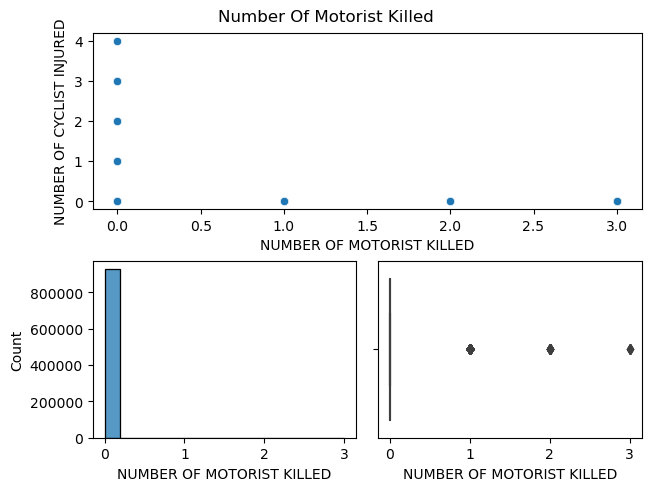

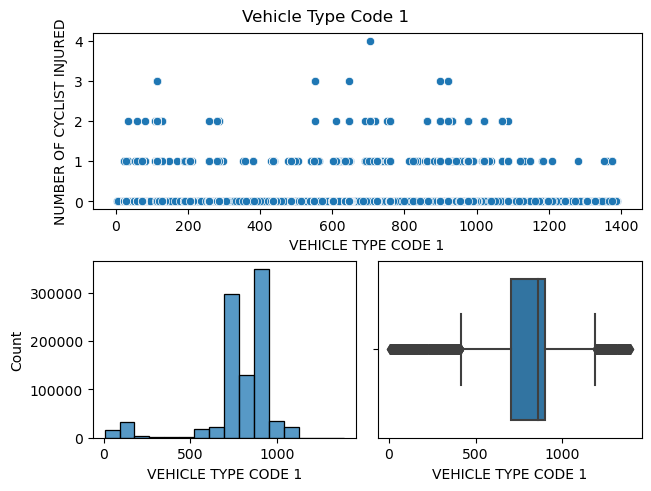

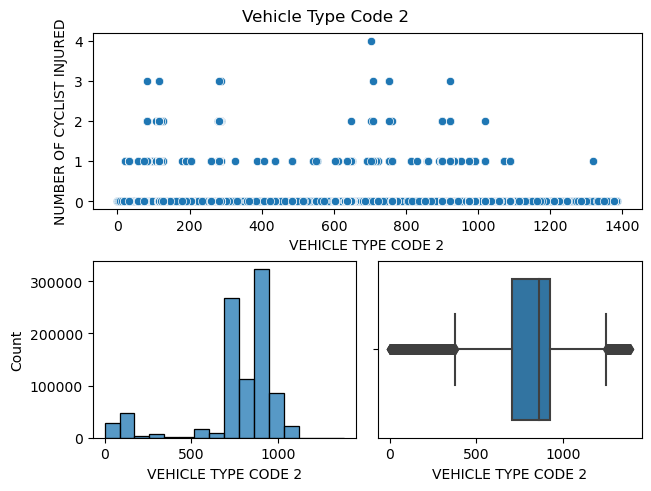

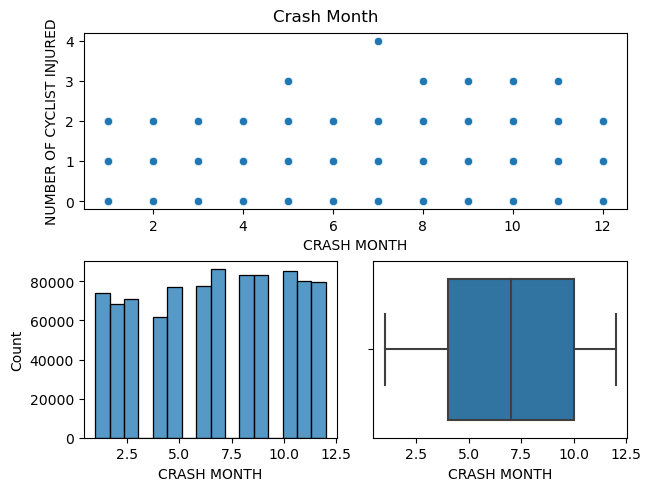

In [86]:
columns = collisions.columns
for idx in range(len(columns)):
    x_value = columns[idx]
    t_value = columns[idx].title()
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    # create sub plots as grid
    ax1 = fig.add_subplot(gs[0, :])
    sns.scatterplot(data=collisions,x=x_value, y='NUMBER OF CYCLIST INJURED')
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(x=x_value,data=collisions,bins=16)
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=collisions,x=x_value,orient='h')
 
    # depict illustration
    fig.suptitle(t_value)
    #fig.savefig('data/graphs/' + x_value + '.png', format='png')
    print('\n')

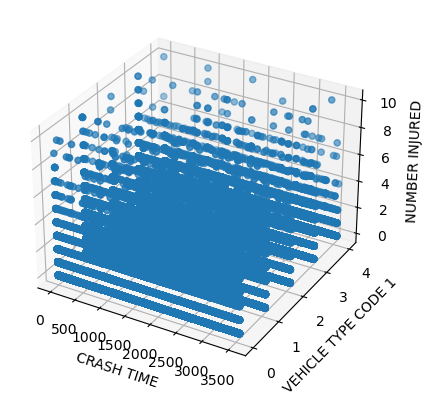

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = collisions['CRASH TIME']
y = collisions['BOROUGH']
z = collisions['NUMBER OF PERSONS INJURED']

ax.set_xlabel("CRASH TIME")
ax.set_ylabel("VEHICLE TYPE CODE 1")
ax.set_zlabel("NUMBER INJURED")

ax.scatter(x, y, z)

### Let's now train the random forest model and evaluate results

In [93]:
# Let's now split the data up
X = collisions[['CRASH TIME','VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2', 'CRASH MONTH', 'ON STREET NAME']]
y = collisions[['NUMBER OF PERSONS INJURED']].to_numpy().flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
# Let's train a decision tree model on this
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

In [ ]:
# Let's see how we did
y_pred = rf.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision 
precision = precision_score(y_test, y_pred,average='weighted', zero_division=0.0) 
# Recall 
recall = recall_score(y_test, y_pred,average='weighted', zero_division=0.0) 
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy of our Decision Tree Model:{accuracy: .3f}')
print(f'Precision of our Decision Tree Model:{precision: .3f}')
print(f'Recall of our Decision Tree Model:{recall: .3f}')
print(f'F1 score of our Decision Tree Model:{f1: .3f}')

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm_disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()